Epoch 1/40 - Train Loss: 29.6844, Train Accuracy: 57.56%, Val Loss: 7.0095, Val Accuracy: 52.84%
Epoch 2/40 - Train Loss: 27.9998, Train Accuracy: 64.44%, Val Loss: 6.6332, Val Accuracy: 58.86%
Epoch 3/40 - Train Loss: 27.3008, Train Accuracy: 66.88%, Val Loss: 6.4939, Val Accuracy: 59.53%
Epoch 4/40 - Train Loss: 26.5665, Train Accuracy: 68.10%, Val Loss: 6.4801, Val Accuracy: 58.86%
Epoch 5/40 - Train Loss: 26.4134, Train Accuracy: 68.46%, Val Loss: 6.2956, Val Accuracy: 63.55%
Epoch 6/40 - Train Loss: 26.1556, Train Accuracy: 69.68%, Val Loss: 6.2536, Val Accuracy: 64.21%
Epoch 7/40 - Train Loss: 25.7382, Train Accuracy: 69.96%, Val Loss: 6.2182, Val Accuracy: 65.55%
Epoch 8/40 - Train Loss: 25.1317, Train Accuracy: 70.90%, Val Loss: 6.1914, Val Accuracy: 63.88%
Epoch 9/40 - Train Loss: 24.7137, Train Accuracy: 71.76%, Val Loss: 6.0836, Val Accuracy: 65.55%
Epoch 10/40 - Train Loss: 24.5455, Train Accuracy: 72.47%, Val Loss: 6.0038, Val Accuracy: 66.89%
Epoch 11/40 - Train Loss: 24.

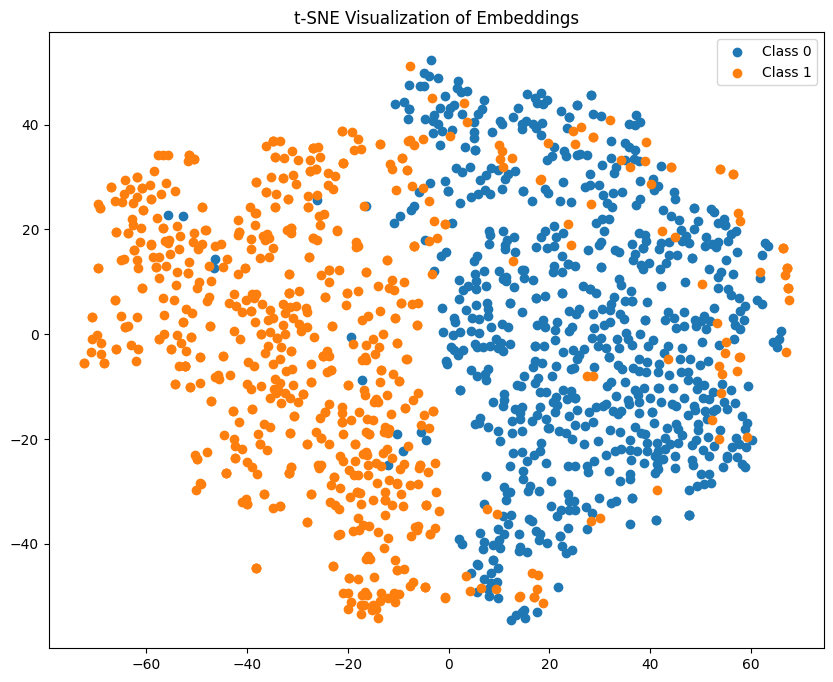

In [1]:
from torch.utils.tensorboard import SummaryWriter
from visualizer import EmbeddingsVisualizer
from model_trainer import ModelTrainer
from cnn_model import CNNModel
from data_processor import ImageDatasetProcessor
from pets_dataset import PetsDataset
import config
from dataset_preparation import DatasetPreparation

config = config.load_config()

data_preparation = DatasetPreparation(config)
transform = data_preparation.preprocess_dataset()

dataset = PetsDataset(config["DATA_PATH"], transform=transform)

data_processor = ImageDatasetProcessor(dataset, config)
train_loader, val_loader, test_loader = data_processor.create_dataloaders()

cnn_model = CNNModel(config).to(config["DEVICE"])


writer = SummaryWriter(log_dir="./runs")
trainer = ModelTrainer(cnn_model, train_loader, val_loader, test_loader, config, writer)
trainer.train()
cnn_model.load_state_dict(trainer.best_model_state)

embedding_visualizer = EmbeddingsVisualizer(cnn_model, train_loader, config)

embeddings, labels = embedding_visualizer.generate_embeddings()
print(f"Сформированные эмбеддинги: {embeddings.shape}")

embedding_visualizer.visualize_embeddings()

Я использовал t-SNE для отображения эмбеддингов из последнего сверточного слоя модели в двумерном пространстве, выделив цветом целевую переменную. Эмбеддинги двух классов (Class 0 — кошки и Class 1 — собаки) хорошо разделены в пространстве. Наблюдаются два кластера: голубого цвета и оранжевого. Между кластерами заметны четкие границы. Это говорит о том, что модель успешно извлекает признаки для разделения классов. 

Эмбеддинги из последнего сверточного слоя модели демонстрируют хорошую кластеризацию, что подтверждает, что модель успешно выделяет ключевые признаки для различия между фотографиями кошек и собак.

In [1]:
from model_evaluator import ModelEvaluator
from tl_model import TransferLearningModel
from cnn_model import CNNModel
from data_processor import ImageDatasetProcessor
from pets_dataset import PetsDataset
import config
from dataset_preparation import DatasetPreparation


config = config.load_config()

dataset_preprocessor = DatasetPreparation(config)
transform = dataset_preprocessor.preprocess_dataset()
dataset = PetsDataset(config["DATA_PATH"], transform)
data_processor = ImageDatasetProcessor(dataset, config)
train_loader, val_loader, test_loader = data_processor.create_dataloaders()

cnn_model = CNNModel(config)
transfer_model = TransferLearningModel(config)

evaluator = ModelEvaluator(config)

comparison_results = evaluator.compare_models(cnn_model, transfer_model, train_loader, val_loader, test_loader)


Evaluating CNN Model...
Epoch 1/50 - Train Loss: 29.2083, Train Accuracy: 59.57%, Val Loss: 7.0705, Val Accuracy: 52.51%
Epoch 2/50 - Train Loss: 27.6197, Train Accuracy: 65.23%, Val Loss: 6.4684, Val Accuracy: 61.54%
Epoch 3/50 - Train Loss: 26.8375, Train Accuracy: 68.10%, Val Loss: 6.3636, Val Accuracy: 64.21%
Epoch 4/50 - Train Loss: 26.2858, Train Accuracy: 69.53%, Val Loss: 6.2610, Val Accuracy: 65.22%
Epoch 5/50 - Train Loss: 26.1399, Train Accuracy: 69.32%, Val Loss: 6.2000, Val Accuracy: 66.22%
Epoch 6/50 - Train Loss: 25.7635, Train Accuracy: 69.68%, Val Loss: 6.1534, Val Accuracy: 66.89%
Epoch 7/50 - Train Loss: 25.3385, Train Accuracy: 70.82%, Val Loss: 6.0519, Val Accuracy: 66.89%
Epoch 8/50 - Train Loss: 25.2256, Train Accuracy: 71.25%, Val Loss: 6.0420, Val Accuracy: 65.89%
Epoch 9/50 - Train Loss: 24.5770, Train Accuracy: 73.69%, Val Loss: 5.9554, Val Accuracy: 67.89%
Epoch 10/50 - Train Loss: 24.5601, Train Accuracy: 72.83%, Val Loss: 5.8957, Val Accuracy: 68.23%
Epoch

Результаты на тестовом наборе:
CNN Model:
Точность: 79.26%, F1-score: 0.7926, что указывает на высокое качество генерализации.
Transfer Learning Model: Точность достигает 89.97%
Также более высокий F1-score(0.8995) показывается чуть лучшее качество классификации для обоих классов (кошки и собаки).

Разница в 10% между точностью и F1-мерой моделей не является значительной, так как обе модели показывают высокие результаты (79% и 89%).

Что касается времени обучения, модель Transfer Learning обучается быстрее (на 635.38 секунд меньше, примерно 21.6% быстрее). Это происходит из-за того, что Transfer Learning модель использует заранее обученные слои, а обучение сфокусировано только на новых слоях.

In [1]:
from datetime import datetime
from model_trainer import ModelTrainer
from cnn_model import CNNModel
from data_processor import ImageDatasetProcessor
from pets_dataset import PetsDataset
import config
from dataset_preparation import DatasetPreparation
from torch.utils.tensorboard import SummaryWriter
from tensorboard.notebook import start, display

config = config.load_config()

data_preparation = DatasetPreparation(config)
transform = data_preparation.preprocess_dataset()

dataset = PetsDataset(config["DATA_PATH"], transform=transform)

data_processor = ImageDatasetProcessor(dataset, config)
train_loader, val_loader, test_loader = data_processor.create_dataloaders()

log_dir = f"./runs/run_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
writer = SummaryWriter(log_dir=log_dir)
model = CNNModel(config).to(config["DEVICE"])

trainer = ModelTrainer(model, train_loader, val_loader, test_loader, config, writer=writer)
trainer.train()
trainer.test()

writer.close()

start(f"--logdir {log_dir}")
display()

Epoch 1/50 - Train Loss: 29.5130, Train Accuracy: 59.28%, Val Loss: 6.8706, Val Accuracy: 55.52%
Epoch 2/50 - Train Loss: 27.6455, Train Accuracy: 67.24%, Val Loss: 6.4651, Val Accuracy: 61.20%
Epoch 3/50 - Train Loss: 26.5155, Train Accuracy: 68.53%, Val Loss: 6.3264, Val Accuracy: 63.55%
Epoch 4/50 - Train Loss: 26.0129, Train Accuracy: 69.68%, Val Loss: 6.2745, Val Accuracy: 65.22%
Epoch 5/50 - Train Loss: 26.0079, Train Accuracy: 69.32%, Val Loss: 6.2179, Val Accuracy: 64.88%
Epoch 6/50 - Train Loss: 25.2612, Train Accuracy: 71.76%, Val Loss: 6.1430, Val Accuracy: 65.55%
Epoch 7/50 - Train Loss: 25.0590, Train Accuracy: 72.26%, Val Loss: 6.0663, Val Accuracy: 68.56%
Epoch 8/50 - Train Loss: 24.6255, Train Accuracy: 72.90%, Val Loss: 6.0672, Val Accuracy: 67.89%
Epoch 9/50 - Train Loss: 24.0680, Train Accuracy: 73.33%, Val Loss: 5.8917, Val Accuracy: 69.90%
Epoch 10/50 - Train Loss: 23.9167, Train Accuracy: 74.05%, Val Loss: 5.9400, Val Accuracy: 68.23%
Epoch 11/50 - Train Loss: 23.

Selecting TensorBoard with logdir ./runs/run_2025-01-09_19-31-51 (started 0:00:00 ago; port 6006, pid 11748).


Анализ графиков и метрик из tensorboard.
График Train Loss. Значения уменьшаются плавно на протяжении всех эпох, что говорит о хорошем процессе обучения.
К концу обучения значение потерь сильно снизилось (с ~30 до ~7), что указывает на высокую точность модели на обучающем наборе данных.
На графике Validation Loss значения также плавно уменьшаются и к 50 эпохе находятся примерно на одном уровне, что говорит о том, что модель не переобучается.
Анализ метрики точности.
Train Accuracy:
Точность постепенно увеличивается до ~93% к последним эпохам.
Validation Accuracy:
Точность на валидационном наборе растет стабильно и достигает максимума в районе 83% на 44-й эпохе. После этого точность остается стабильной.

Тестовая выборка:
Test Loss: 4.0930.
Test Accuracy: 80.6%.
Результаты тестовой выборки достаточно близки к валидационным метрикам. Разница между Train Accuracy и Test Accuracy также небольшая и точность модели на тестовой выборке(80.6%) высокая, что говорит о хорошей генерализации модели.


Код для повторного просмотров логов в tensorboard

In [1]:
%reload_ext tensorboard
%tensorboard --logdir runs/run_2025-01-09_19-31-51 --port=6010

Код для повторного просмотра логов в tensorboard
